In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
# Select GPU
torch.cuda.set_device(4)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.interactive import *
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils
from wrappers.multilingual_transformer_wrapper import FairseqMultilingualTransformerHub

from fairseq.data.multilingual.multilingual_utils import (
    EncoderLangtok,
    LangTokSpec,
    LangTokStyle,
    augment_dictionary,
    get_lang_tok,
)

import alignment.align as align

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

Choose model size (small/big), data mode (generate/interactive), generation mode (teacher forcing/free decoding), and dataset.

In [14]:
model_size = 'small' # small (412M) /big (1.2B)
data_sample = 'interactive' # generate/interactive
teacher_forcing = False # teacher forcing/free decoding
dataset = 'flores'

In [4]:
# Paths
# Checkpoint path
ckpt_dir = Path(os.environ['M2M_CKPT_DIR'])
#iwslt14_dir = Path("./data/iwslt14")
europarl_dir = Path("./data/de-en")
flores_dir = Path("./data/flores")

# Path to binarized data
if data_sample == 'generate':
    m2m_data_dir = Path(os.environ['M2M_DATA_DIR'])
    data_name_or_path=(f'{m2m_data_dir}/data_bin')
else:
    # use "." to avoid loading
    data_name_or_path='.'

# Checkpoint names
if model_size=='big':
    checkpoint_file = '1.2B_last_checkpoint.pt'
else:
    checkpoint_file = '418M_last_checkpoint.pt'

lang_flores_dict = {'en': 'eng', 'es': 'spa', 'zu': 'zul',
                    'de': 'deu', 'yo': 'yor', 'ms': 'msa',
                    'fr': 'fra', 'xh': 'xho'}
source_lang = 'en'
target_lang = 'es'

In [5]:
hub = FairseqMultilingualTransformerHub.from_pretrained(
    ckpt_dir,
    checkpoint_file=checkpoint_file,
    data_name_or_path=data_name_or_path,
    source_lang= source_lang,
    target_lang= target_lang,
    lang_pairs =f'{source_lang}-{target_lang}',
    fixed_dictionary=f'{ckpt_dir}/model_dict.128k.txt')
NUM_LAYERS = 12

2022-06-15 01:22:05 | WARNING | fairseq.data.multilingual.multilingual_data_manager | External language dictionary is not provided; use lang-pairs to infer the set of supported languages. The language ordering is not stable which might cause misalignment in pretraining and finetuning.


## Get example for analysis

From provided test data (preprocessed folder)

In [7]:
if data_sample=='generate':
    # index in dataset
    i = 0

    sample = hub.get_sample('test', i)

    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    src_tok = sample['src_tok']
    src_sent = sample['src_sent']
    tgt_sent = sample['tgt_sent']
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")


Source sentence: 	 __de__ wir glauben nicht , daß wir nur rosinen herauspicken sollten .</s>
Target sentence: 	 __en__ we do not believe that we should cherry-pick .</s>


### Get sample as interactive from tokenized file

In [6]:
def prepare_input_encoder(hub, tok_sentence):
    generator = hub.task.build_generator(hub.models, hub.cfg)
    max_positions = utils.resolve_max_positions(
    hub.task.max_positions(), *[model.max_positions() for model in hub.models]
    )
    def encode_fn(x):
        return x
    batch = make_batches(tok_sentence,hub.cfg,hub.task,max_positions,encode_fn)
    src_tensor = next(batch).src_tokens
    src_tok = [hub.task.target_dictionary[t] for t in src_tensor[0]]
    return src_tok, src_tensor[0] # first element in batch

def prepare_input_decoder(hub, tok_sentence):
    tok_sentence = tok_sentence.split()
    lang = hub.task.args.langtoks["main"][1]
    if lang == 'tgt':
        lang_tok = hub.task.args.target_lang
    else:
        lang_tok = hub.task.args.source_lang
    lang_tok = get_lang_tok(lang=lang_tok, lang_tok_style=LangTokStyle.multilingual.value)
    tgt_tok = [hub.task.target_dictionary[hub.task.target_dictionary.eos_index]] + [lang_tok] + tok_sentence
    tgt_tensor = torch.tensor([hub.task.target_dictionary.index(t) for t in tgt_tok])
    return tgt_tok, tgt_tensor

In [7]:
if data_sample=='interactive':

    # if dataset == 'iwslt':
    #     test_set_dir = iwslt14_dir
    if dataset == 'gold':
        test_set_dir = europarl_dir# / "processed_data/"
    elif dataset == 'flores':
        test_set_dir = flores_dir
    if dataset == 'flores':
        src = lang_flores_dict[source_lang]
        tgt = lang_flores_dict[target_lang]
    else:
        src = "en"
        tgt = "de"

    tokenizer = "spm"

    # index in dataset
    i = 6
    sample = hub.get_interactive_sample(i, test_set_dir,
                                        src, tgt, tokenizer,
                                        prepare_input_encoder,
                                        prepare_input_decoder)

    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    src_tok = sample['src_tok']
    tgt_tok = sample['tgt_tok']

    print(sample['src_word_sent'])
    print(sample['tgt_word_sent'])

He built a WiFi door bell, he said.

Él dijo que construyó un timbre wifi.



### Teacher Forcing

In [10]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)
    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
    #target_sentence = ['</s>'] + [tgt_lan_token] + tgt_tok



GREEDY DECODING

Predicted sentence: 	 __fr__ Construl constru que construyó una teléfonoón de,</s>


### Greedy decoding/Beam search

For greedy decoding, set beam=1

In [20]:
if not teacher_forcing:
    tgt_tensor_free = []
    print("\n\nBEAM SEARCH\n")
    # We provide src_tensor[1:] since hub.generate internally
    # adds the language tag for generating translations
    for pred in hub.generate(src_tensor[1:], beam=1,verbose=True):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.target_dictionary, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]

    pred_tok = hub.decode(pred['tokens'], hub.task.target_dictionary, as_string=False)
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.target_dictionary.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, hub.task.target_dictionary, as_string=False)
    target_sentence = tgt_tok
    #pred_tok = tgt_tok
    #pred_tok = pred['tokens']

    # model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor_forward, tgt_tensor)

    # print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    # pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    # pred_tok2 = hub.decode(pred_tensor, hub.task.target_dictionary)
    # pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    # print(f"Predicted sentence: \t {pred_sent}")



BEAM SEARCH

-0.8379719257354736 	 __es__ Construyó una llamada de puerta WiFi, dijo.</s>


In [21]:
source_sentence = src_tok
target_sentence = tgt_tok
predicted_sentence = pred_tok

## ALTI analysis

### ALTI of the encoder

To check the mixing of information inside the decoder. Visualization show with and without main diagonal

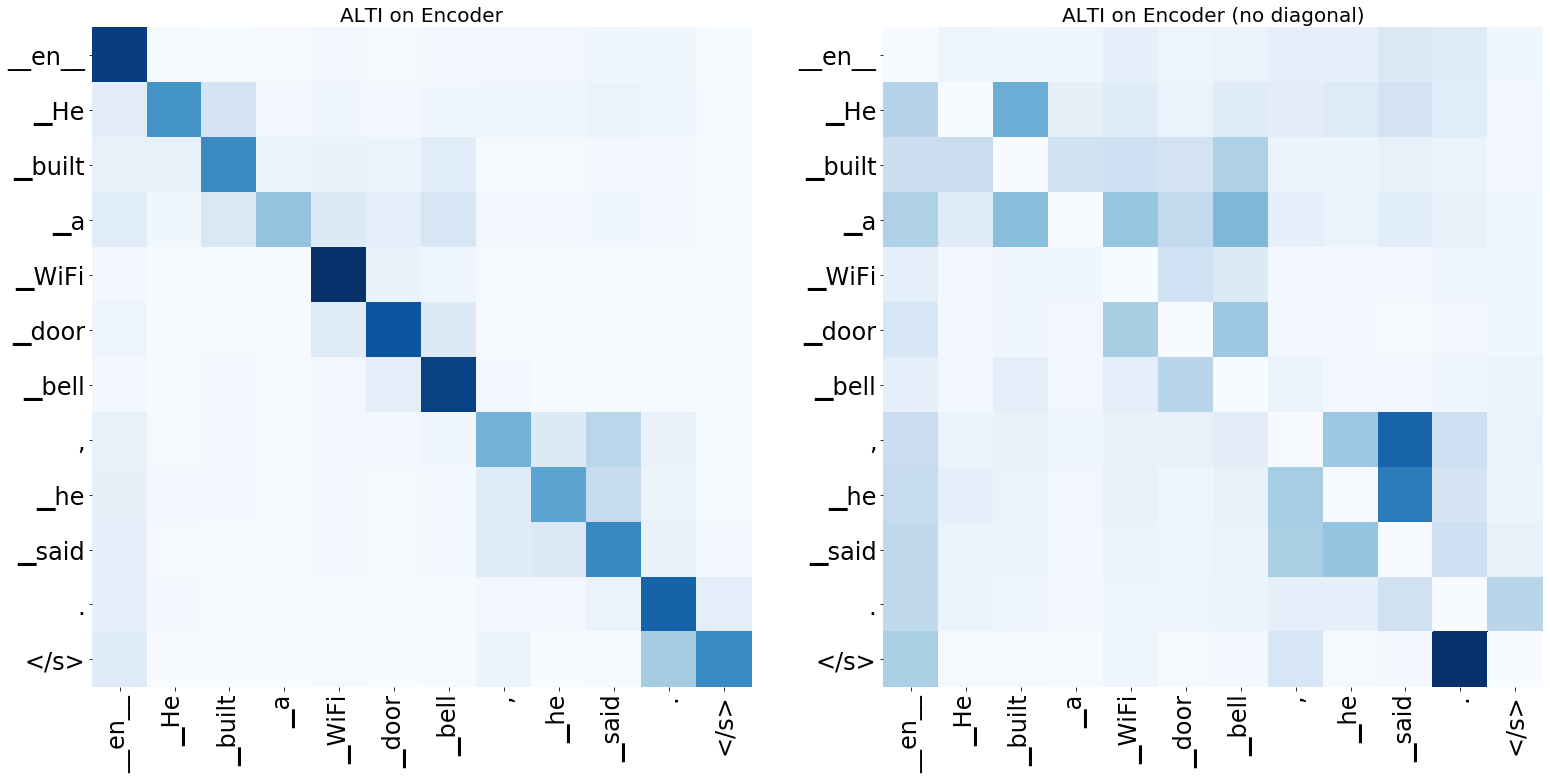

In [22]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                        norm_mode='min_sum', pre_layer_norm=True)['encoder.self_attn']
layer = -1                                                        
# Encoder self-attention relevances in last layer (full encoder ALTI)
fig = plt.figure(figsize=(26, 14))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
relevances_enc_self_attn_last = relevances_enc_self_attn[layer]
relevances_enc_self_attn_last_no_diag = relevances_enc_self_attn_last - torch.diag(relevances_enc_self_attn_last.diag())
df = pd.DataFrame(relevances_enc_self_attn_last.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.set(font_scale=0.7)
sns.heatmap(df,cmap="Blues",ax=ax_left,square=True, cbar=False)
ax_left.set_title('ALTI on Encoder', fontsize=20)

df = pd.DataFrame(relevances_enc_self_attn_last_no_diag.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.heatmap(df,cmap="Blues",ax=ax_right,square=True, cbar=False)
ax_right.set_title('ALTI on Encoder (no diagonal)', fontsize=20)
plt.gcf().subplots_adjust(bottom=0.2)

Attention weights (raw) in the cross attention at selected layer.
Corresponds to Figure 8-a of the paper

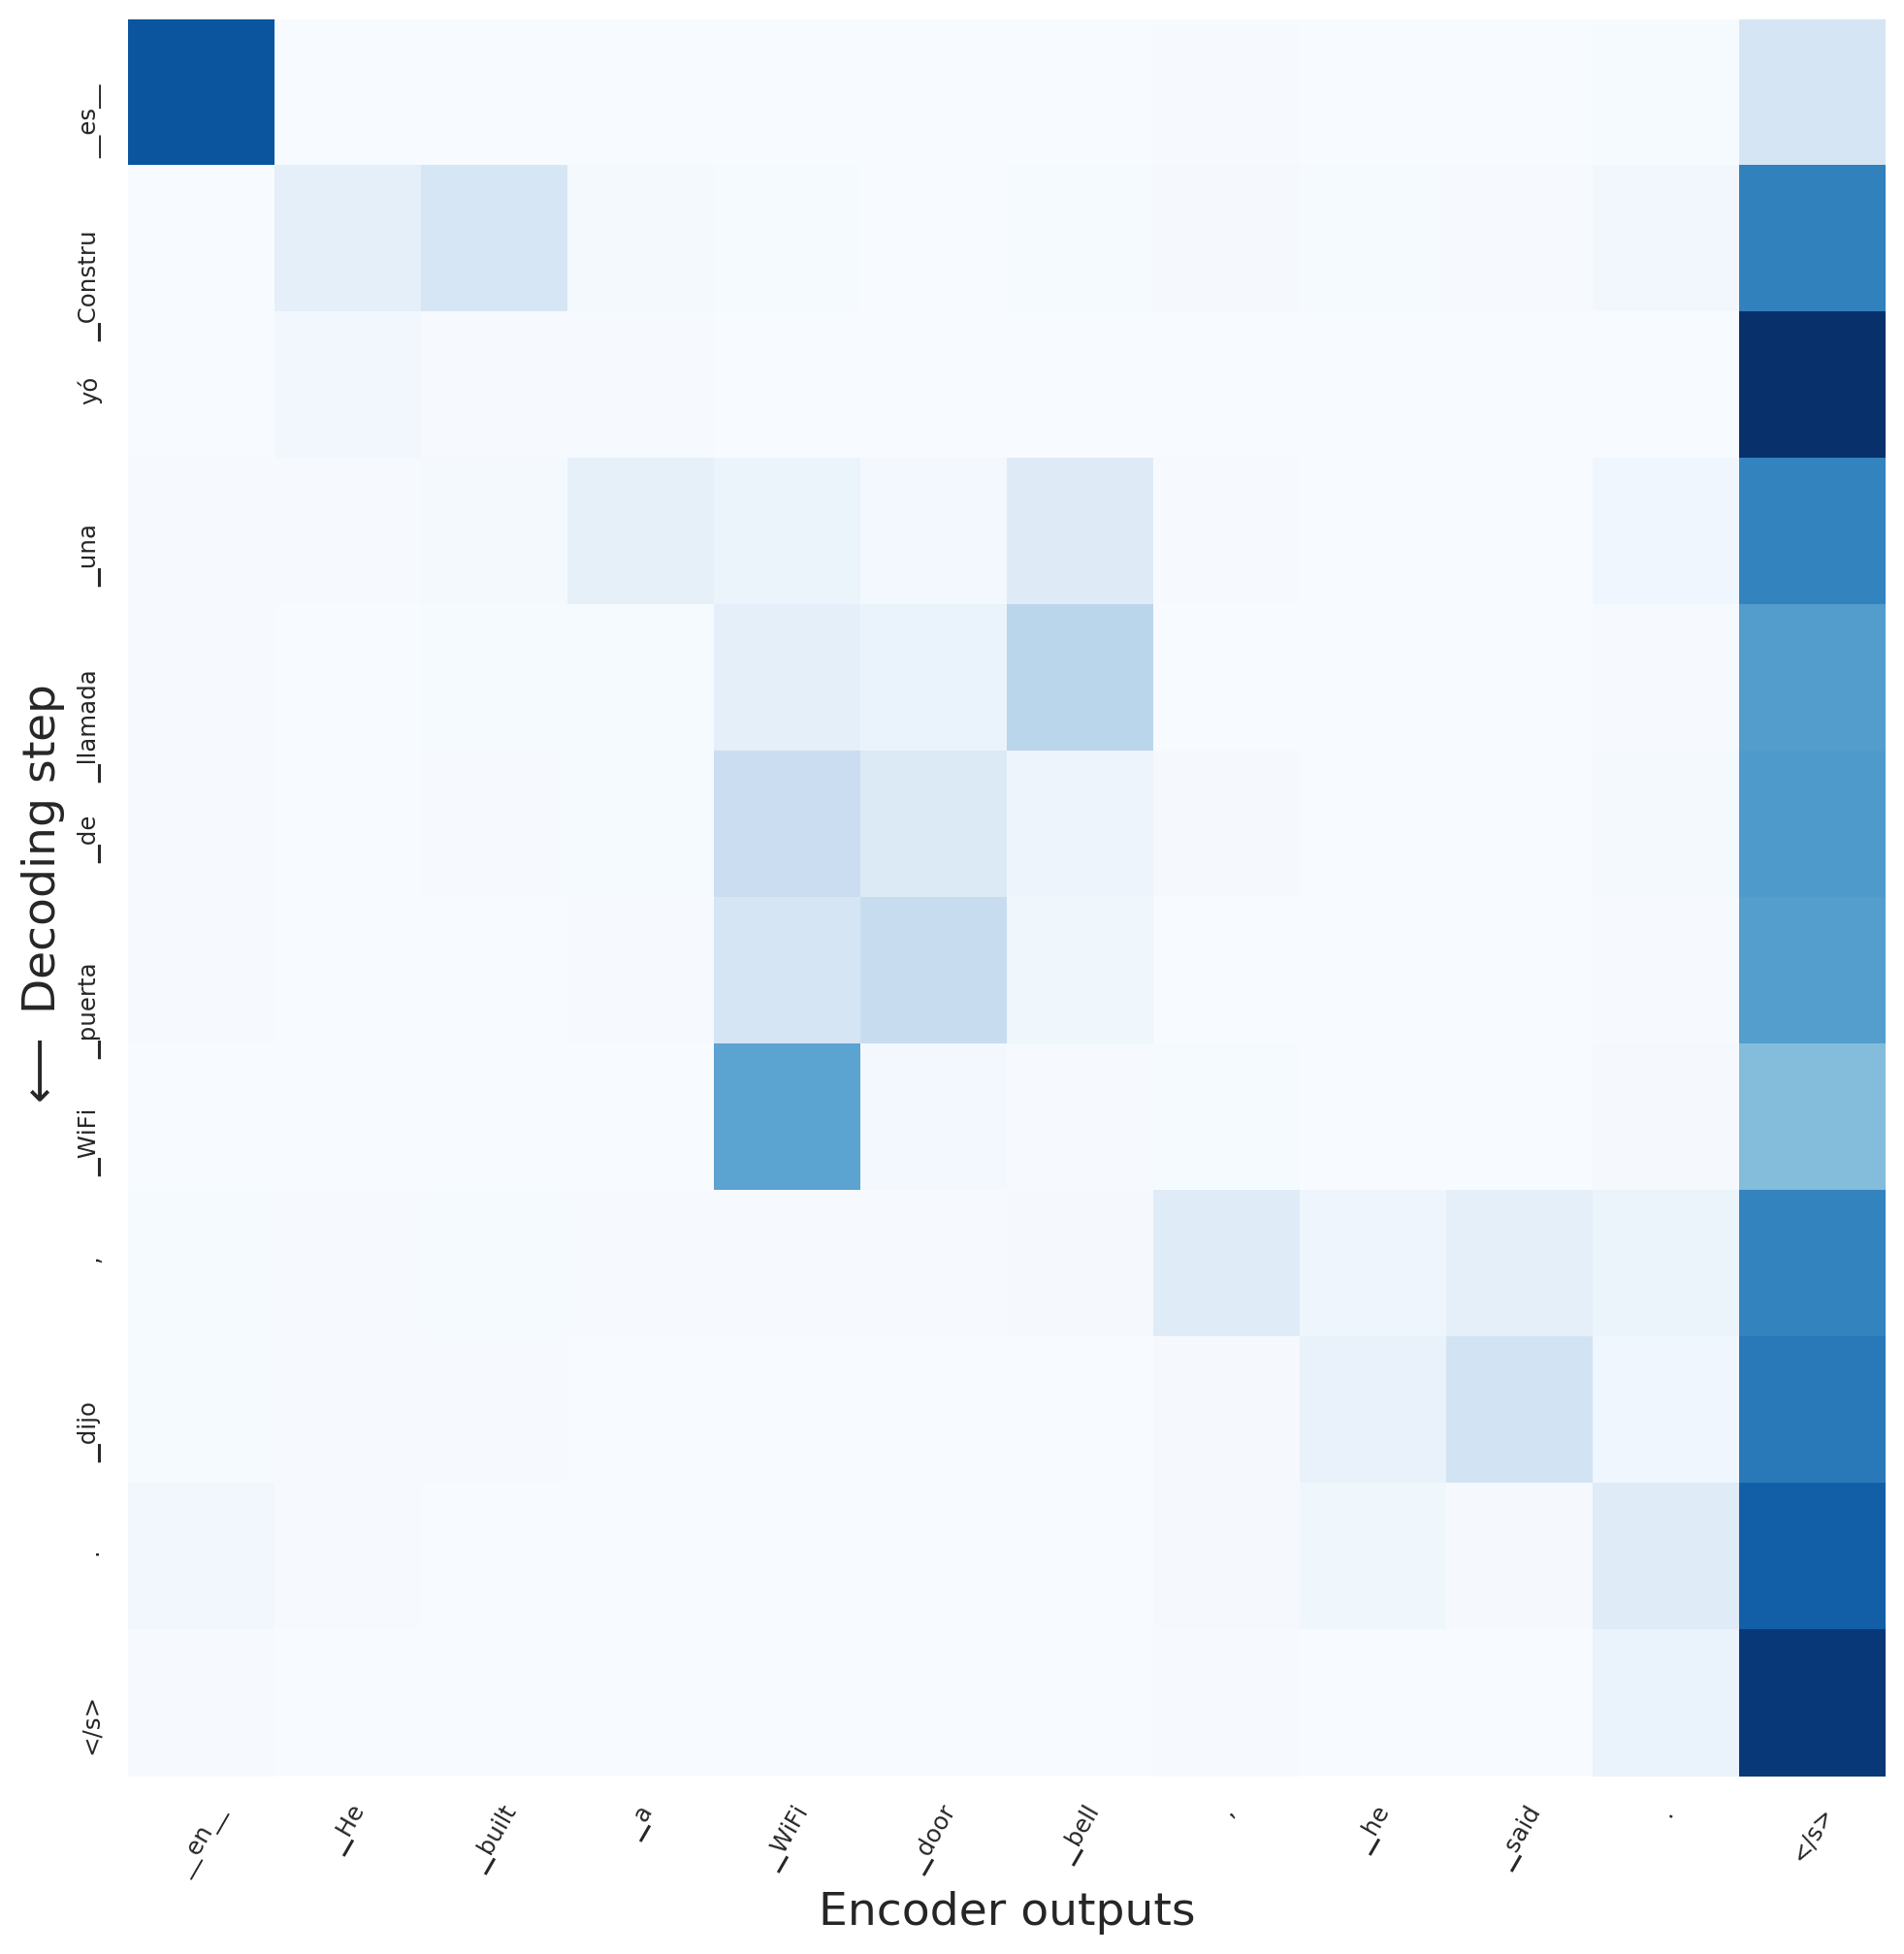

In [33]:
layer = 9

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w',
                                                                norm_mode='sum_one',pre_layer_norm=True)['decoder.encoder_attn'])

cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(12,12),dpi=200)

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence ,index=predicted_sentence)
sns.set(font_scale=0.8)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel('Encoder outputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(rotation=60);

Cross-attention contributions $[\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{e}};\mathbf{C}_{\widetilde{\mathbf{y}}\gets\widetilde{\bm{y}}^{s}_{t}}]$ of the encoder outputs $\mathbf{e}$ and residual $\widetilde{\bm y}_{t}^{s}$ to the decoder layer output.

Corresponds to Figure 8-b of the paper.

mean residual 0.91374975 std 0.059536196


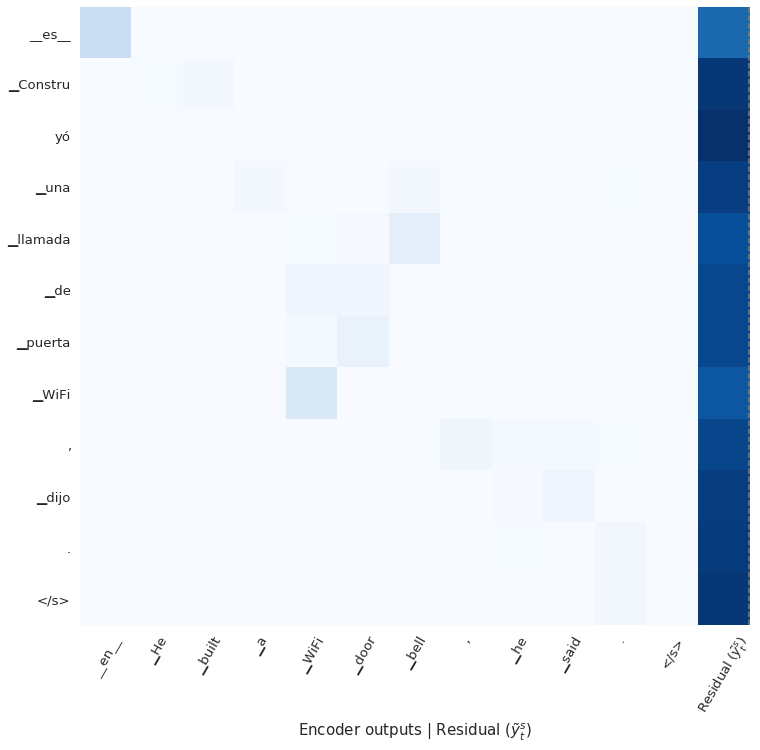

In [34]:
cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor,
                                        tgt_tensor, 'l1', norm_mode='min_sum',
                                        pre_layer_norm=True)['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()

layer = 9
plt.figure(figsize=(12,12))

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['Residual'],index=predicted_sentence)
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel(r'Encoder outputs | Residual $(\tilde{y}^{s}_{t})$', fontsize=15)
#s.set_ylabel('Prediction at step (t)', fontsize=14)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(ticks = plt.gca().get_xticks(), labels=source_sentence + [r'Residual $(\tilde{y}^{s}_{t})$'], rotation=60)

plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

print('mean residual',df['Residual'].mean(), 'std', df['Residual'].std())


### ALTI+

ALTI+ for the entire model. Last layer heatmap shows relevances of input tokens to the model prediction: $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{x}}$ | $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{\mathbf{y}_{<t}}}$

In [28]:
total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor,
                                            'l1', norm_mode='min_sum',
                                            pre_layer_norm=True)['total']

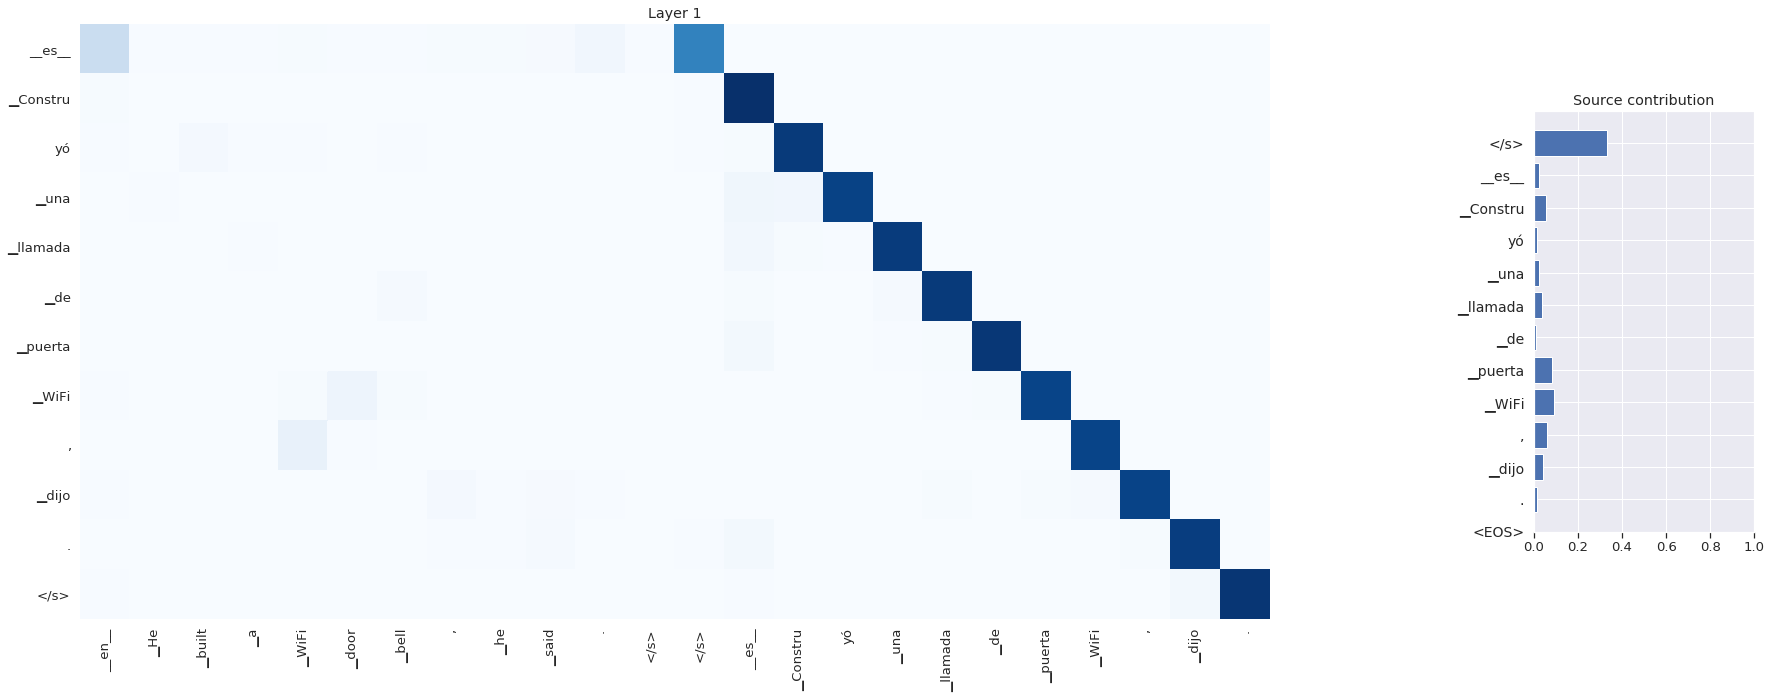

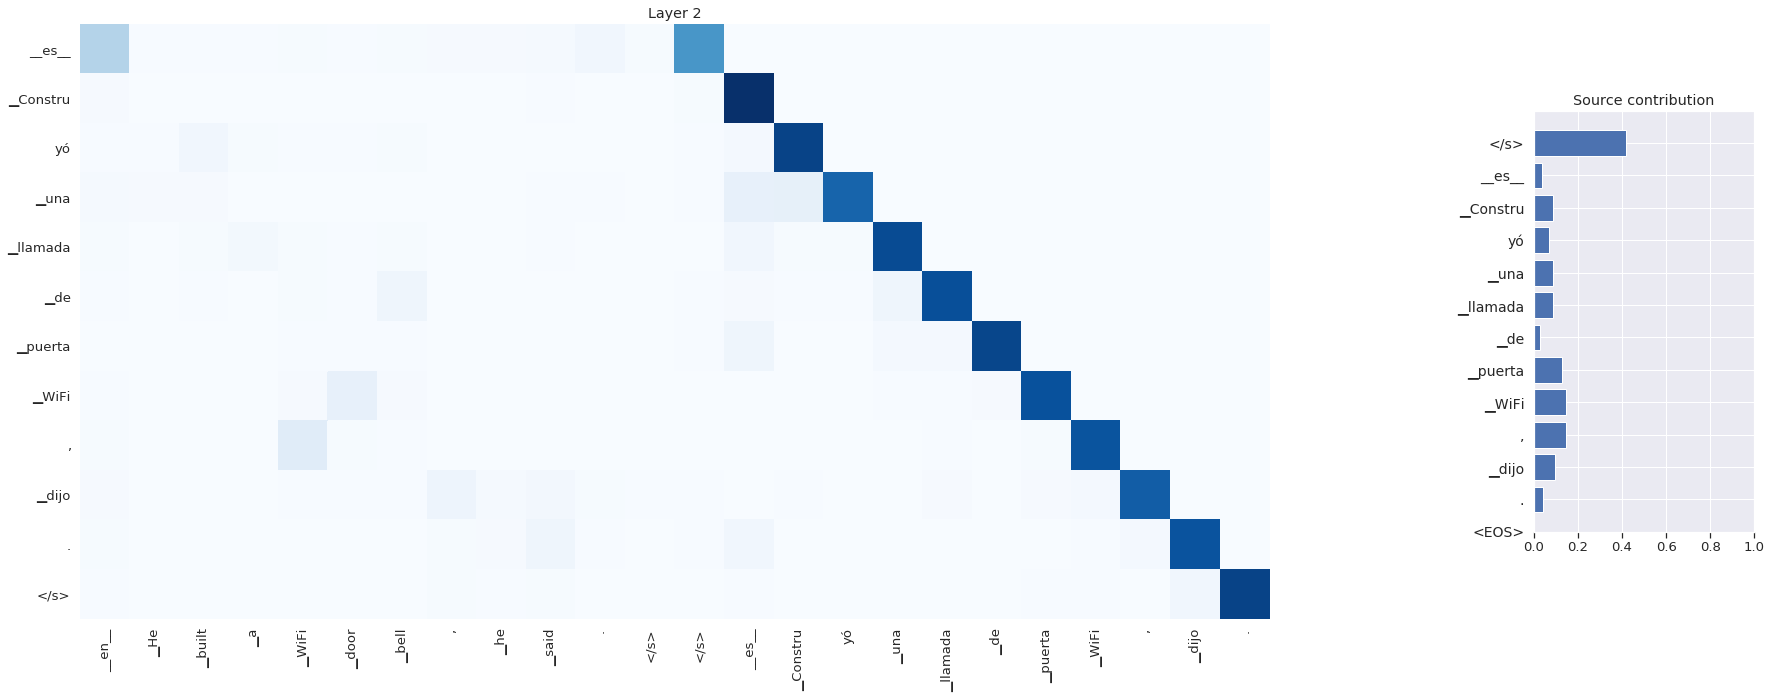

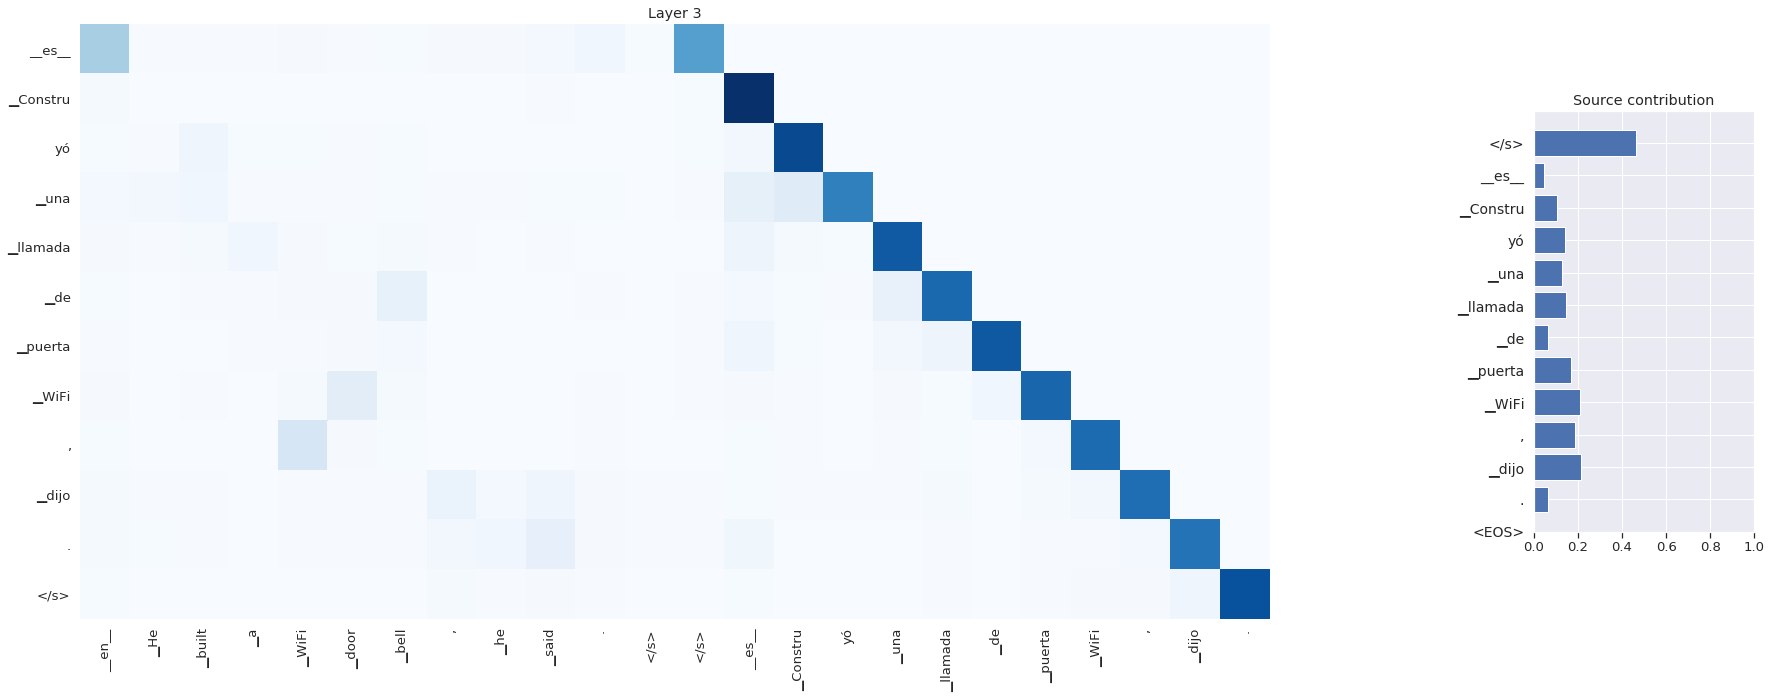

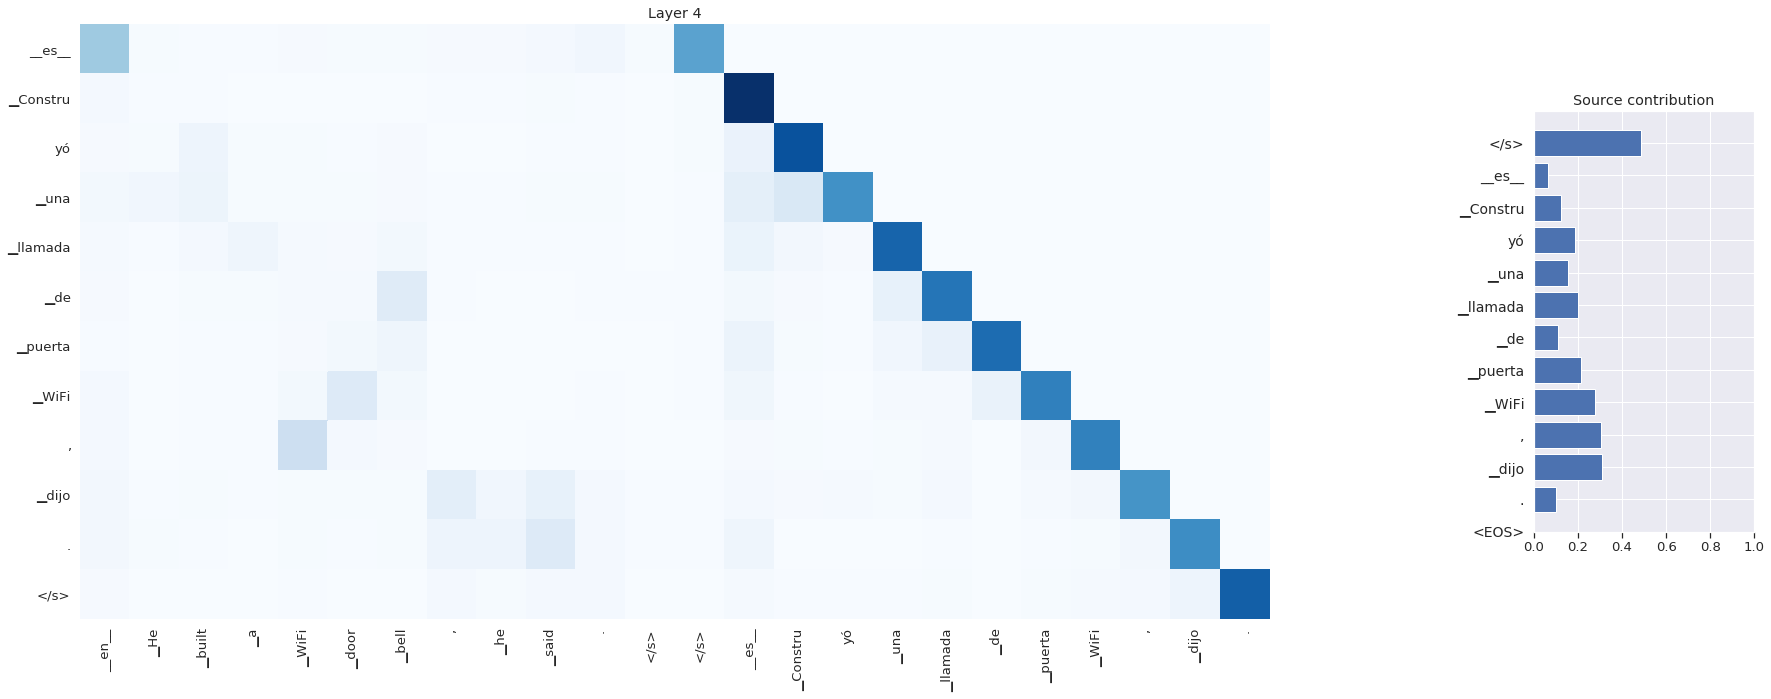

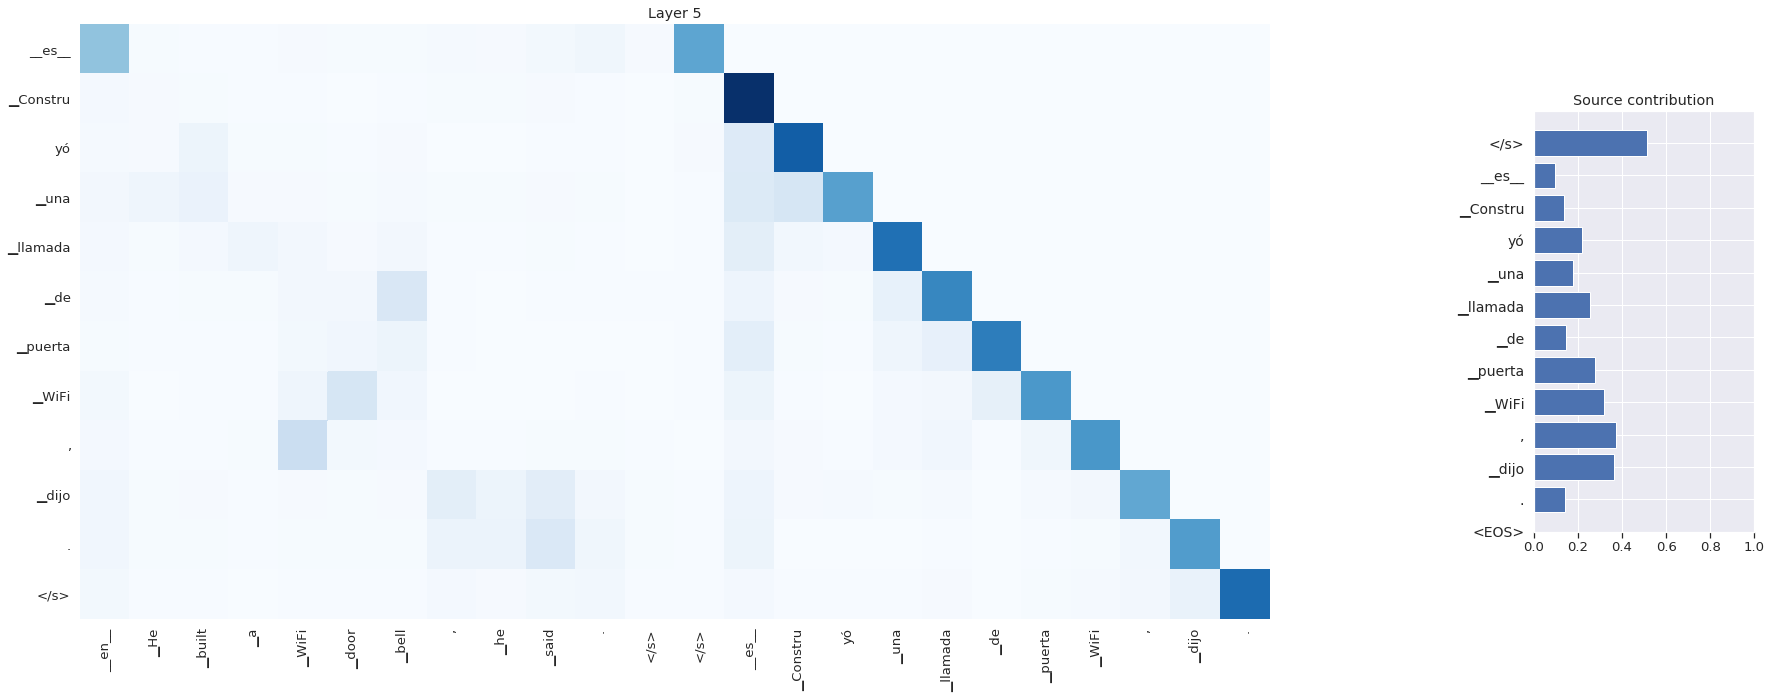

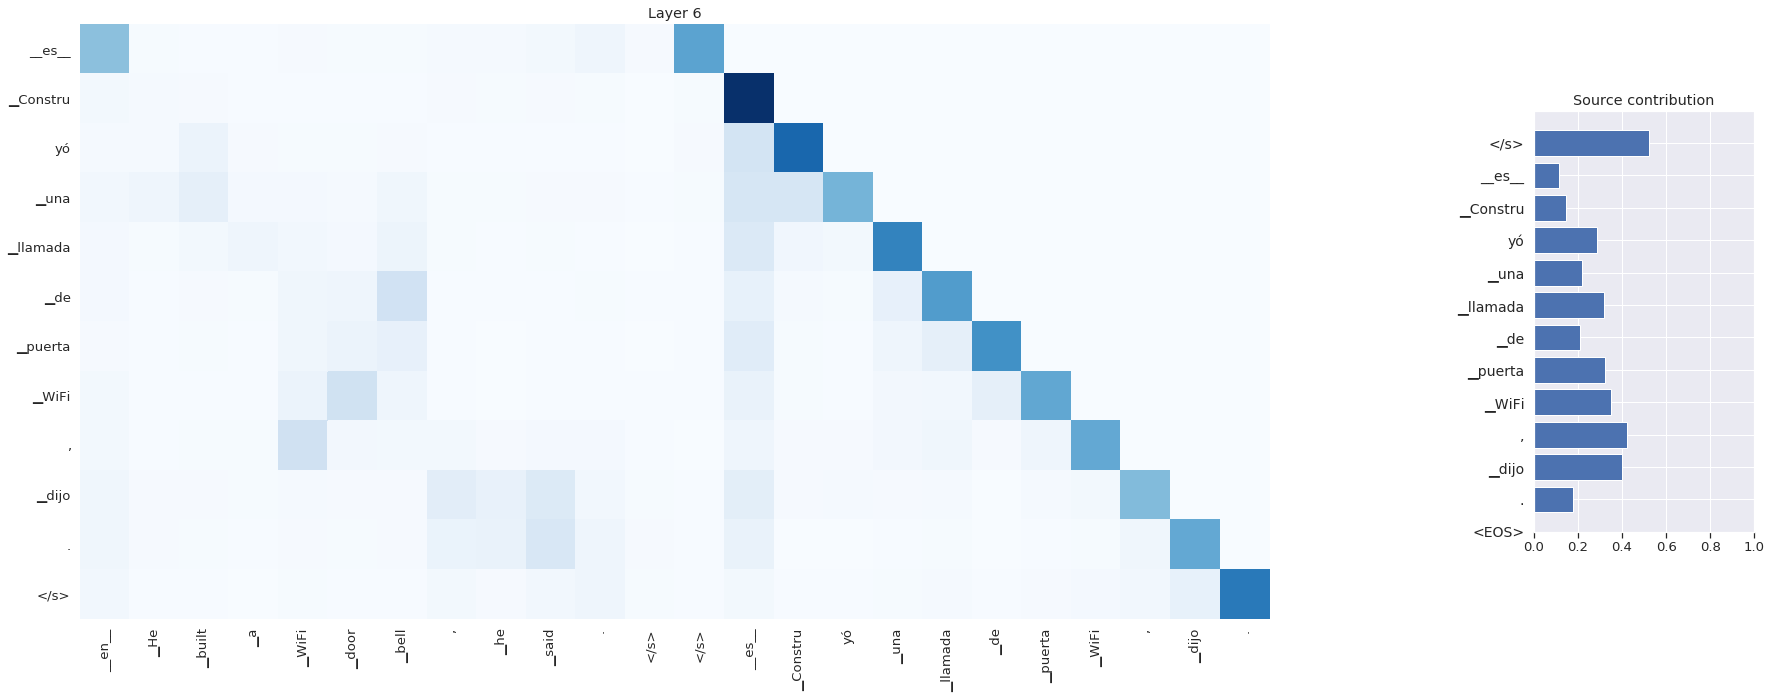

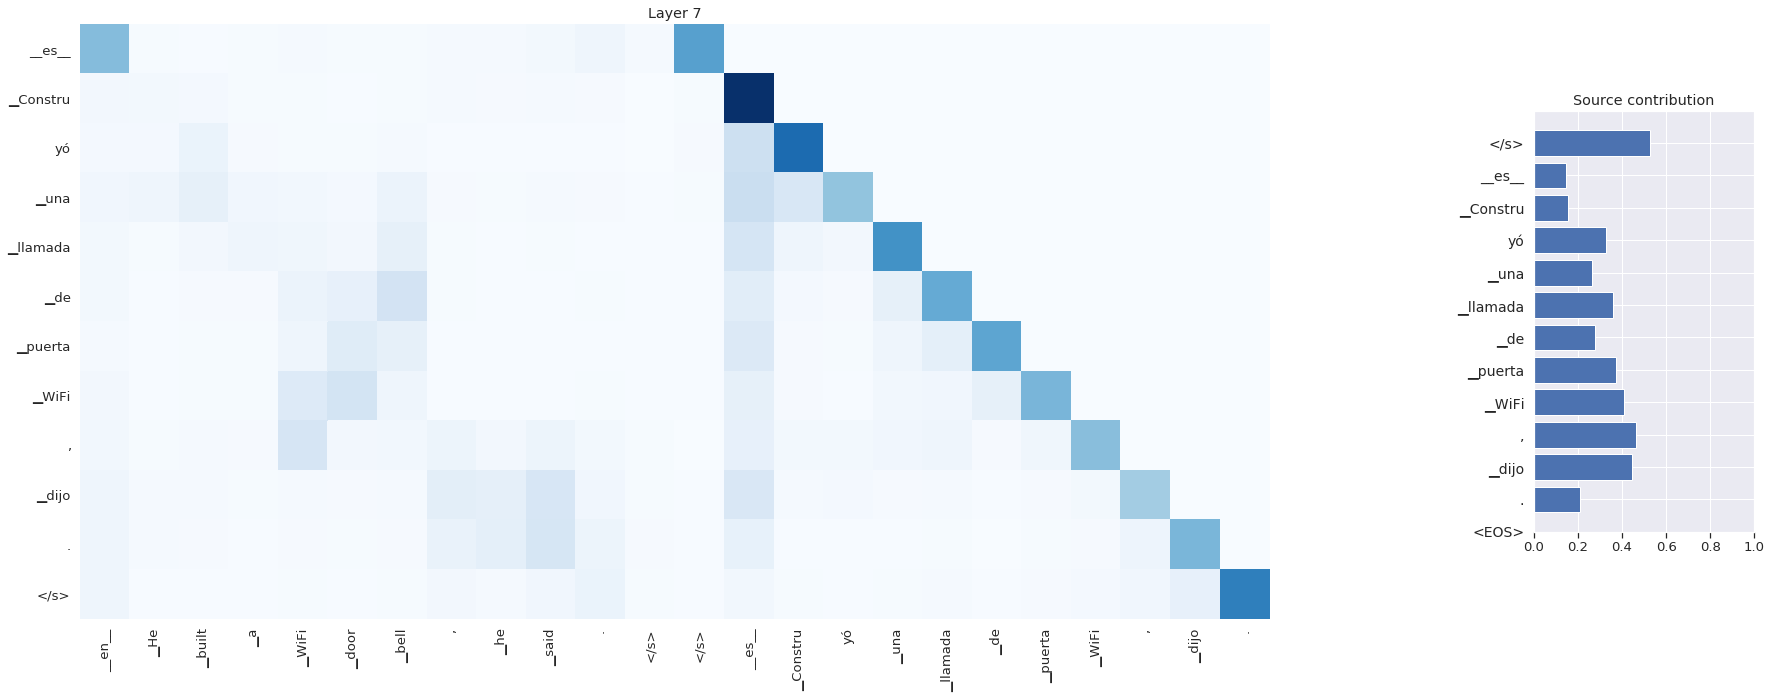

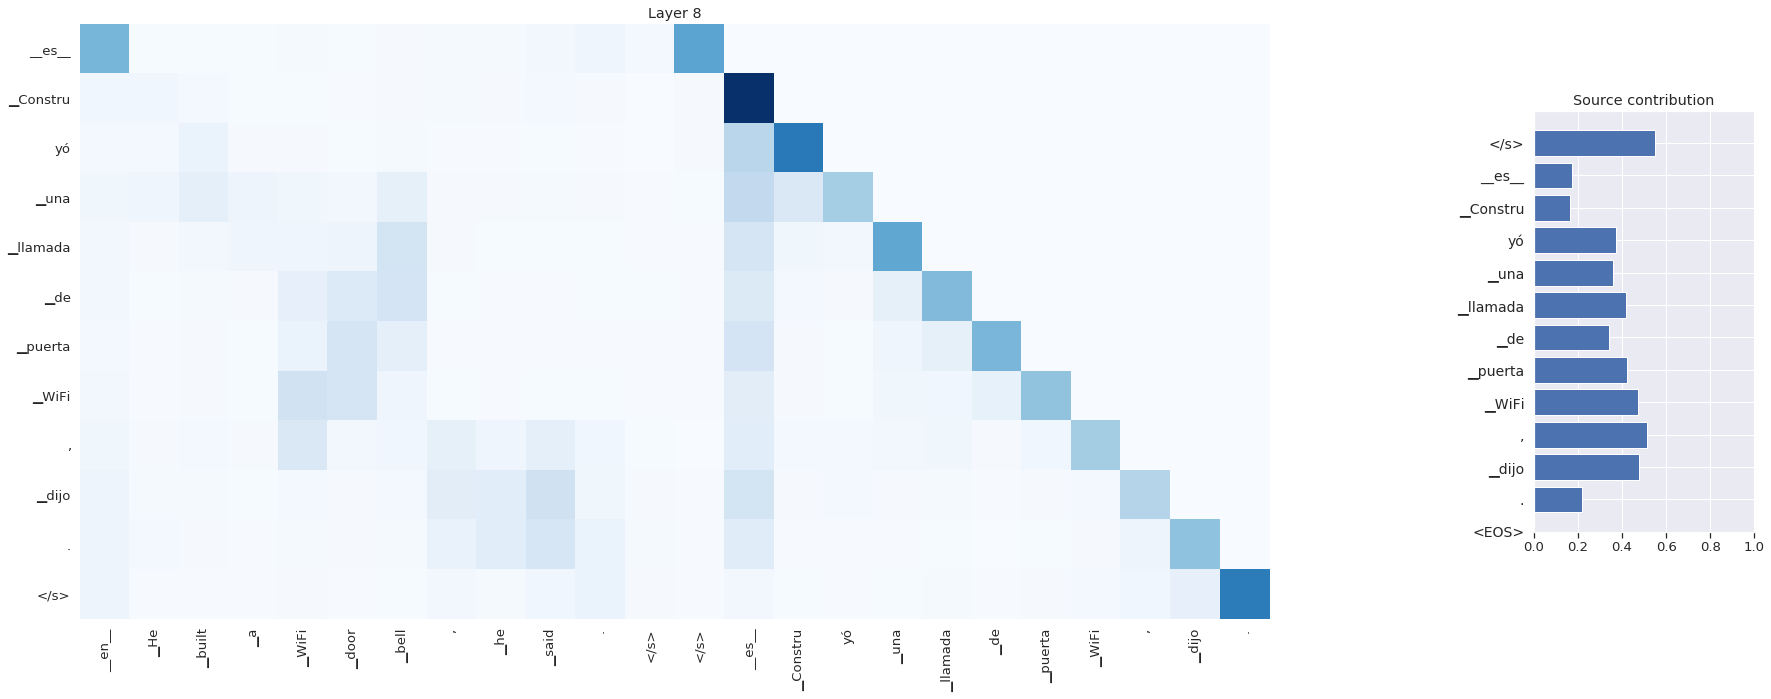

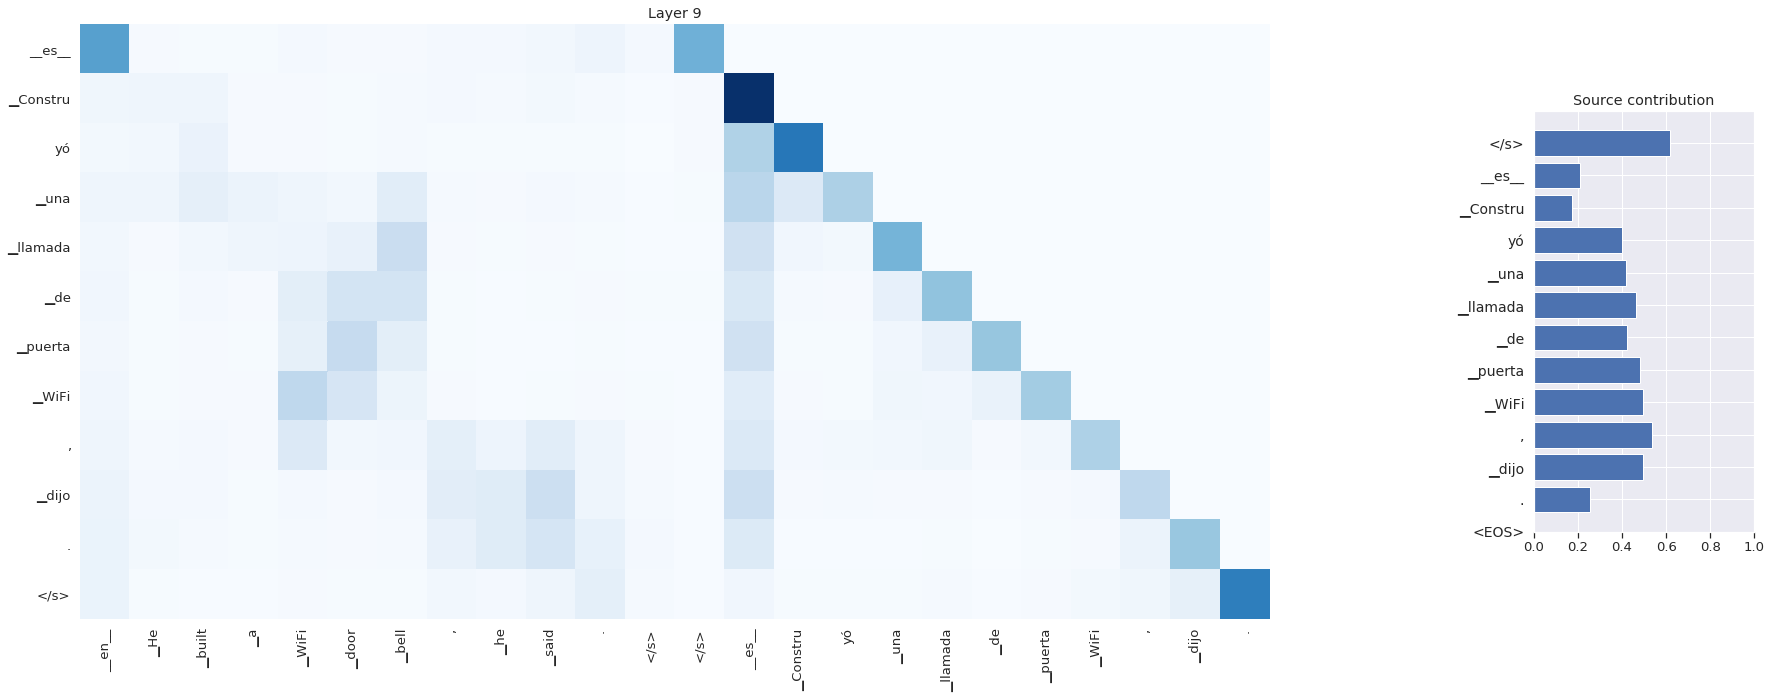

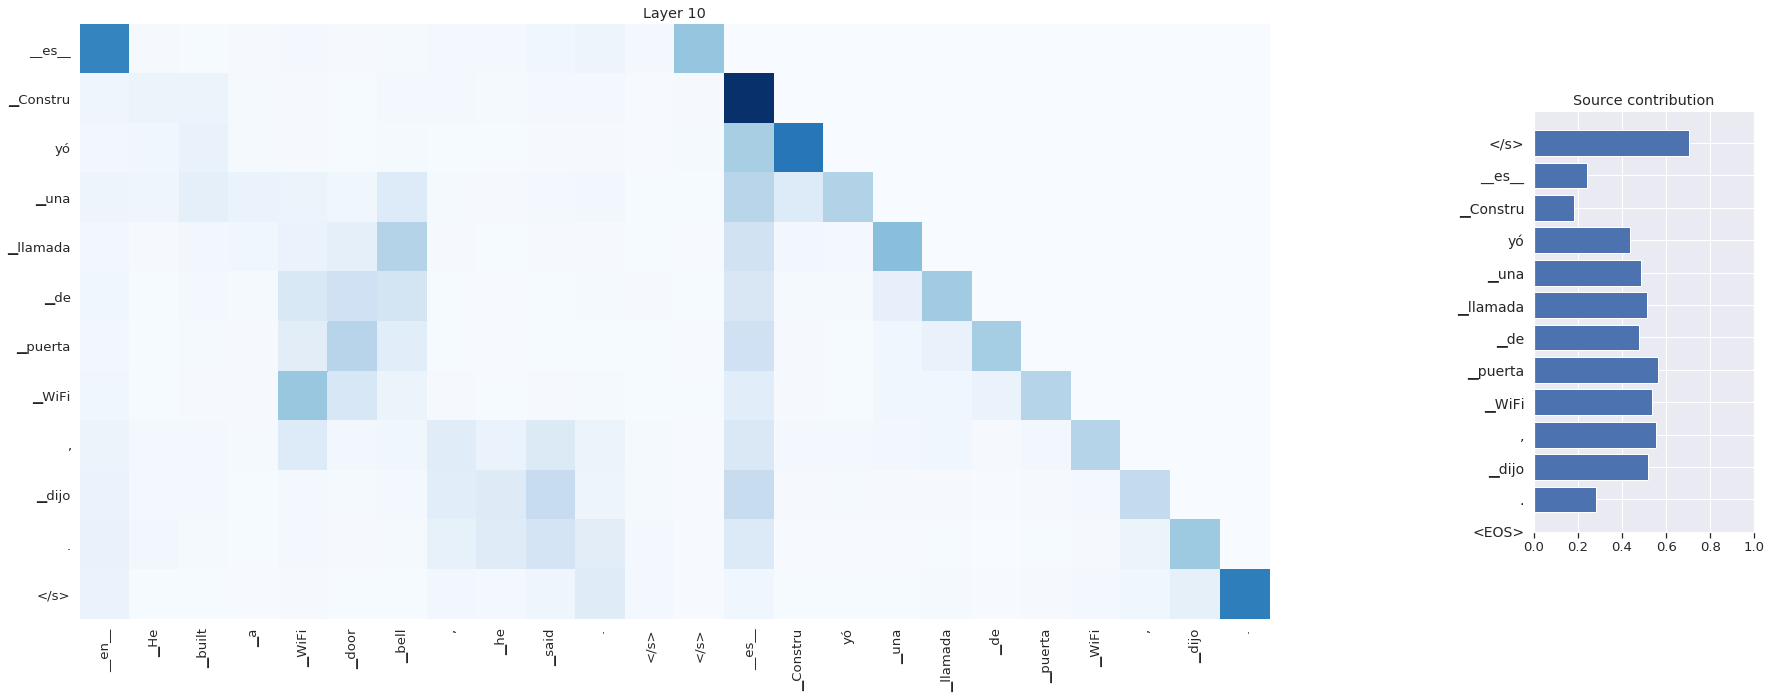

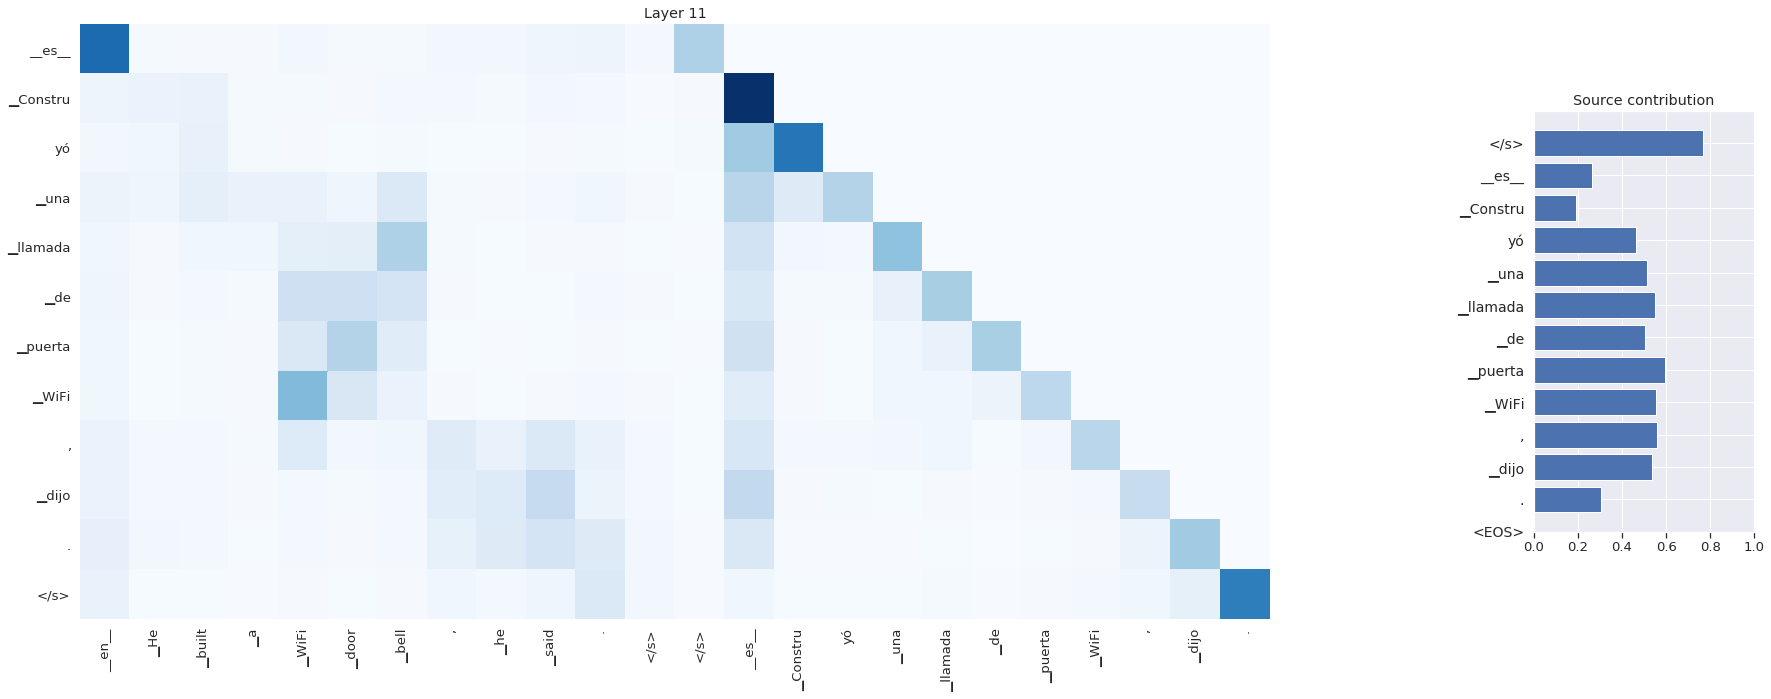

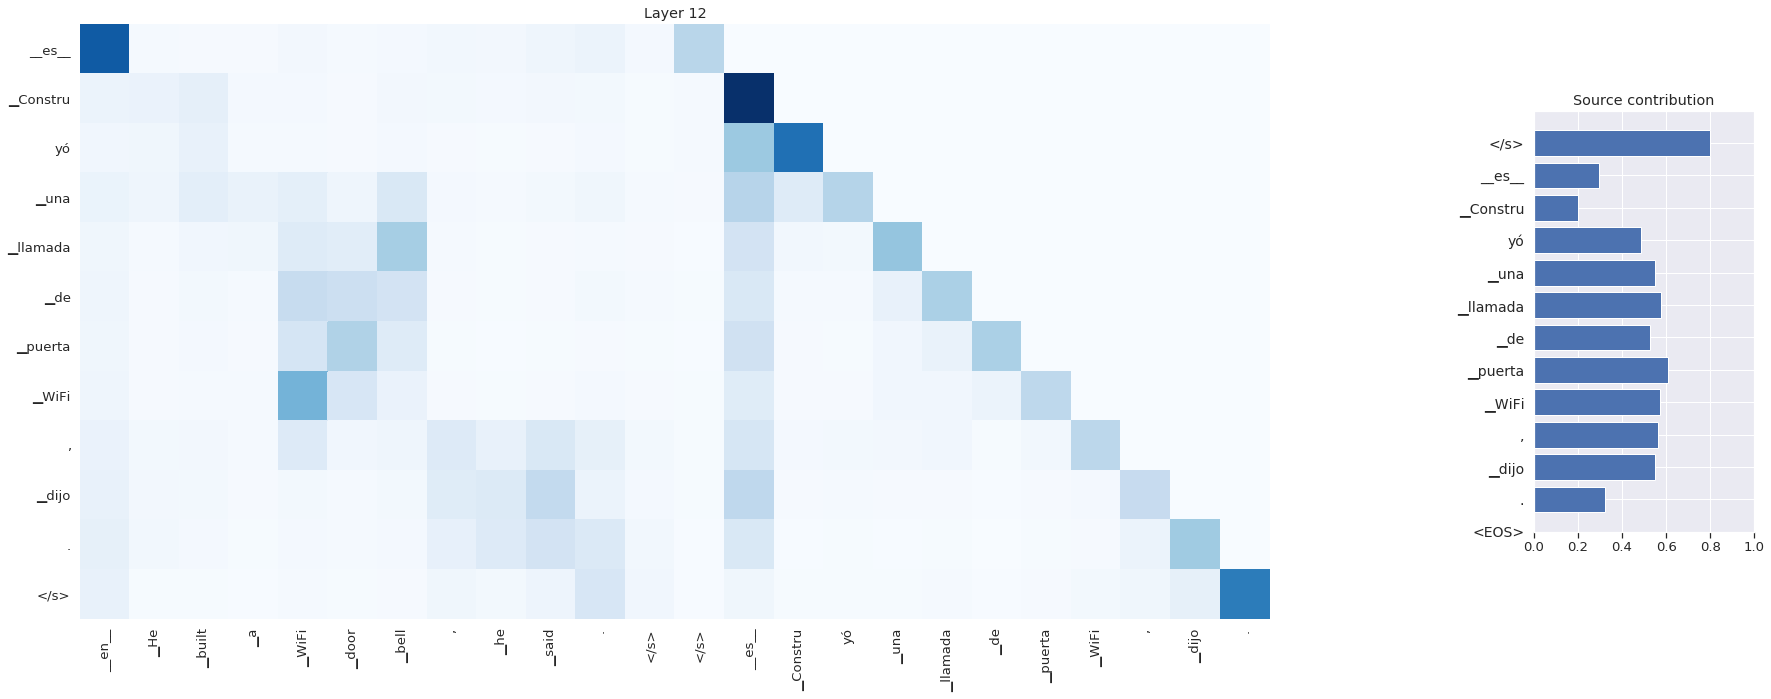

In [29]:
for layer in range(0,NUM_LAYERS):

    fig = plt.figure(figsize=(30, 24))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_alti[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = source_sentence + target_sentence, index = predicted_sentence)
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_rollout_layer_np[:,:src_tensor.size(0)].sum(-1)

    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = target_sentence)
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(target_sentence)), df_src_contribution.src_contribution, align='center')
    plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = target_sentence + ['<EOS>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer+1))
    ax_yDist.set_title('Source contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
    #plt.gcf().subplots_adjust(bottom=0.2)

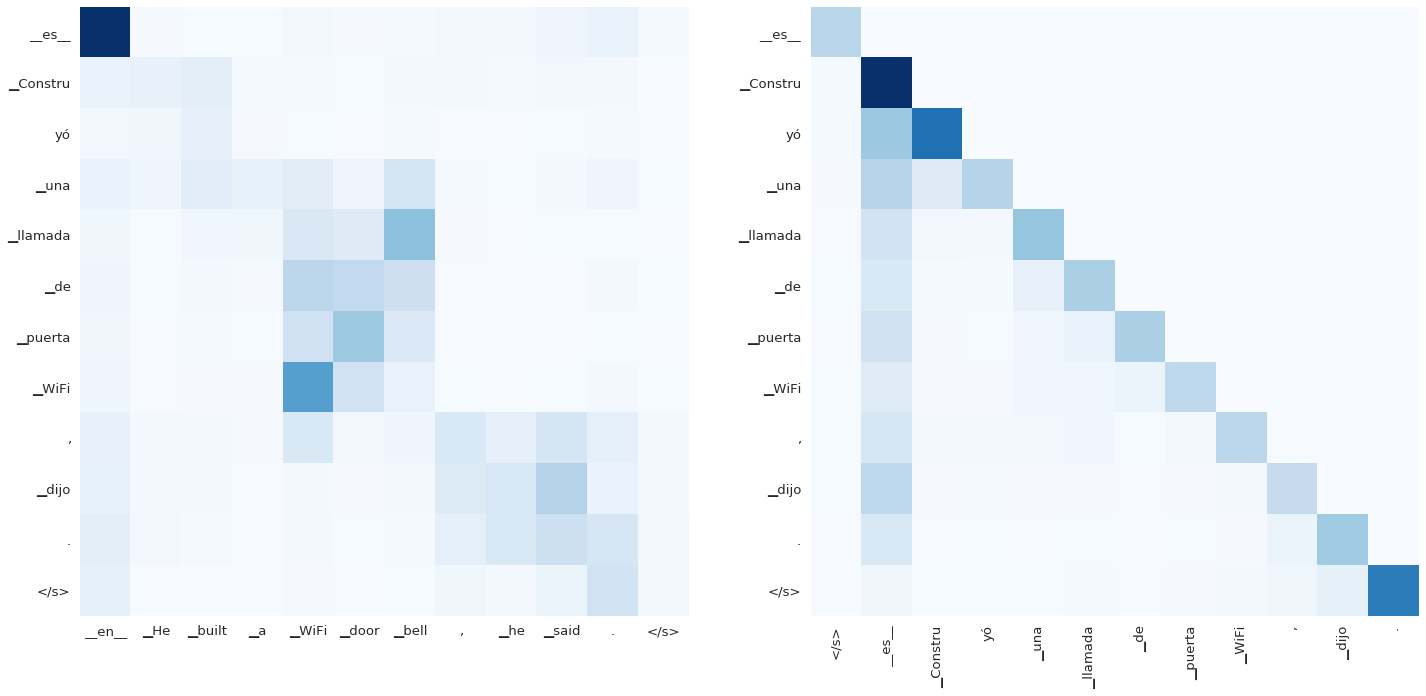

In [30]:
# Separated plots for ALTI+ in last layer
fig = plt.figure(figsize=(24, 14))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
df = pd.DataFrame(contributions_rollout_layer_np[:,:len(source_sentence)], columns = source_sentence, index = predicted_sentence)
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True,ax=ax_left,cbar=False)
df = pd.DataFrame(contributions_rollout_layer_np[:,len(source_sentence):len(source_sentence)+len(target_sentence)], columns = target_sentence, index = predicted_sentence)
sns.heatmap(df,cmap="Blues",square=True,ax=ax_right,cbar=False)
plt.gcf().subplots_adjust(bottom=0.2)

In [31]:
def merge_contributions(source_sentence, target_sentence, word_bpe_contributions):
    target_words_list = ['</s>'] + ''.join(target_sentence[1:]).replace('▁', ' ').split()
    source_words_list = ''.join(source_sentence[:-1]).replace('▁', ' ').split() + ['</s>']
    words_list = source_words_list + target_words_list
    word_i = 0
    word_to_bpe = [[] for _ in range(len(words_list))]
    for bpe_i, token in enumerate(source_sentence + target_sentence):
        if token == '</s>' or token.startswith("__"):
            word_i += 1
        if token.startswith("▁"):
            word_i += 1
        word_to_bpe[word_i-1].append(bpe_i)
    words_contrib = []
    for word in word_to_bpe:
        word_contrib_sum = 0
        for subword in word:
            word_contrib_sum += word_bpe_contributions[subword]
        words_contrib.append(word_contrib_sum)
    return words_list, words_contrib

In [32]:
word_bpe_contributions = list(total_alti[-1][8].detach().cpu().numpy())
words_list, words_contrib = merge_contributions(source_sentence, target_sentence, word_bpe_contributions)

## Word-word alignments (source-target) from contributions

Currently only works for teacher forcing

In [21]:
src_tok_str = ' '.join(source_sentence[:-1])
src_word_sent = ''.join(source_sentence[:-1]).replace('▁', ' ')

In [22]:
target_sentence[0] = '</s>▁'#▁__en__'
tgt_tok_str = ' '.join(target_sentence)
tgt_word_sent = ''.join(target_sentence).replace('▁', ' ')

In [23]:
tgt_splited_bpe_sent = tgt_word_sent.split()[1:]
splited_word_sent = tgt_tok_str.split()[1:]

In [26]:
contribution_pred_src = contributions_rollout_layer_np[:,:len(source_sentence)]#[:,1:] # delete first row
src_word_to_bpe = align.convert_bpe_word(src_tok_str.split(), src_word_sent.split())
print(src_word_to_bpe)
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str.split()[1:], tgt_word_sent.split()[1:])
contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)
contributions_word_word.shape

[[0], [1, 2], [3], [4], [5, 6, 7, 8, 9], [10, 11], [12], [13], [14, 15, 16, 17, 18], [19], [20], [21], [22], [23, 24, 25, 26], [27], [28, 29], [30]]


(17, 17)

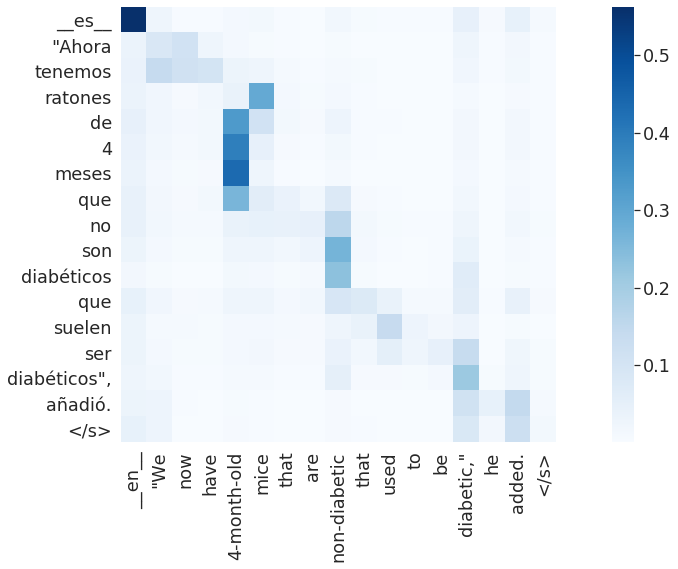

In [25]:
## Soft alignment
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split()[1:] + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

[ 0  0  3  3  2  2  8 10  8  8 11]


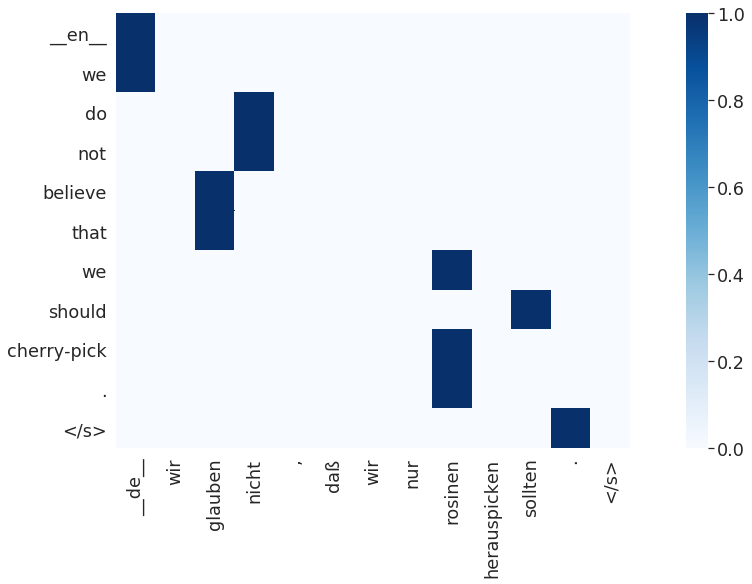

In [21]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
print(a_argmax)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split()[1:] + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);